# Pandas and duckdb

## Task 0 - Load the sakila sqlite database into a duckdb database file

In [3]:
import duckdb 

with duckdb.connect("data/sakila.duckdb") as conn:
    description = conn.sql("DESC").df()

description

,database,schema,name,column_names,column_types,temporary
0,sakila,staging,_dlt_loads,"[load_id, schema_name, status, inserted_at, sc...","[VARCHAR, VARCHAR, BIGINT, TIMESTAMP WITH TIME...",False
1,sakila,staging,_dlt_pipeline_state,"[version, engine_version, pipeline_name, state...","[BIGINT, BIGINT, VARCHAR, VARCHAR, TIMESTAMP W...",False
2,sakila,staging,_dlt_version,"[version, engine_version, inserted_at, schema_...","[BIGINT, BIGINT, TIMESTAMP WITH TIME ZONE, VAR...",False
3,sakila,staging,actor,"[actor_id, first_name, last_name, last_update,...","[DECIMAL(38,9), VARCHAR, VARCHAR, TIMESTAMP, V...",False
4,sakila,staging,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, VA...",False
5,sakila,staging,category,"[category_id, name, last_update, _dlt_load_id,...","[BIGINT, VARCHAR, TIMESTAMP, VARCHAR, VARCHAR]",False
6,sakila,staging,city,"[city_id, city, country_id, last_update, _dlt_...","[BIGINT, VARCHAR, BIGINT, TIMESTAMP, VARCHAR, ...",False
7,sakila,staging,country,"[country_id, country, last_update, _dlt_load_i...","[BIGINT, VARCHAR, TIMESTAMP, VARCHAR, VARCHAR]",False
8,sakila,staging,customer,"[customer_id, store_id, first_name, last_name,...","[BIGINT, BIGINT, VARCHAR, VARCHAR, VARCHAR, BI...",False
9,sakila,staging,film,"[film_id, title, description, release_year, la...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, BI...",False


# Read all data into dictionary of pandas dataframes

In [2]:
dfs = {}

with duckdb.connect("data/sakila.duckdb") as conn:
    for name in description["name"]:
        dfs[name] = conn.sql(f"FROM staging.{name};").df()
        duckdb.register(name, dfs[name])

dfs.keys()

dict_keys(['_dlt_loads', '_dlt_pipeline_state', '_dlt_version', 'actor', 'address', 'category', 'city', 'country', 'customer', 'film', 'film_actor', 'film_category', 'inventory', 'language', 'payment', 'rental', 'staff', 'store'])

## Task 1

### Which movies are longer than 3 hours (180 minutes), show the title and its length?

In [ ]:
long_movies = duckdb.sql("""
SELECT title, length AS duration
FROM films
WHERE length > 180; 
""").df()

long_movies.head()

### Which movies have the word "love" in its title? Show the following columns
#### title
#### rating
#### length
#### description

In [ ]:
love_word = duckdb.sql("""
SELECT title, rating, length, description 
FROM films
WHERE title ILIKE '%love%'; 
""").df()

love_word.head()

### Calculate descriptive statistics on the length column, The Manager wants, shortest, average, median and longest movie length

In [ ]:
aggregate_function = duckdb.sql("""
SELECT 
    MIN(length) AS min_length_movies, 
    ROUND(AVG(length)) AS mean_length_movies, 
    MEDIAN(length) AS median_length_movies, 
    MAX(length) AS max_length_movies
FROM films
""").df()


aggregate_function

### The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can keep the movie. The Manager wants to know the 10 most expensive movies to rent per day.

In [ ]:
rental_rate = duckdb.sql("""
SELECT title, rental_rate, rental_duration, (rental_rate / rental_duration) AS cost_per_day                
FROM films
ORDER BY cost_per_day DESC;
""").df()

rental_rate.head(10)

In [ ]:
description

###  Which actors have played in most movies? Show the top 10 actors with the number of movies they have played in.

In [6]:
top_10_actors = duckdb.sql("""
SELECT a.actor_id, a.first_name, a.last_name, COUNT(*) AS film_count                
FROM actor a
JOIN film_actor fa ON a.actor_id = fa.actor_id
GROUP BY a.actor_id, a.first_name, a.last_name
ORDER BY film_count DESC;
""").df()

top_10_actors

,actor_id,first_name,last_name,film_count
0,107.0,GINA,DEGENERES,42
1,102.0,WALTER,TORN,41
2,198.0,MARY,KEITEL,40
3,181.0,MATTHEW,CARREY,39
4,23.0,SANDRA,KILMER,37
...,...,...,...,...
195,31.0,SISSY,SOBIESKI,18
196,186.0,JULIA,ZELLWEGER,16
197,199.0,JULIA,FAWCETT,15
198,35.0,JUDY,DEAN,15


# Task 2

### Who are our top 5 customers by total spend? The Manager wants to know so that they can reward them with special offers. Create a bar chart showing the top 5 customers by total spend.

In [11]:
top_5_customers = duckdb.sql("""
SELECT c.customer_id, 
        c.first_name || ' ' || c.last_name AS customer_name, 
        SUM(p.amount) AS total_spend
FROM customer c 
JOIN payment p ON c.customer_id = p.customer_id
GROUP BY c.customer_id, customer_name
ORDER BY total_spend DESC;                            
""").df()

top_5_customers.head()

,customer_id,customer_name,total_spend
0,526,KARL SEAL,221.55
1,148,ELEANOR HUNT,216.54
2,144,CLARA SHAW,195.58
3,137,RHONDA KENNEDY,194.61
4,178,MARION SNYDER,194.61


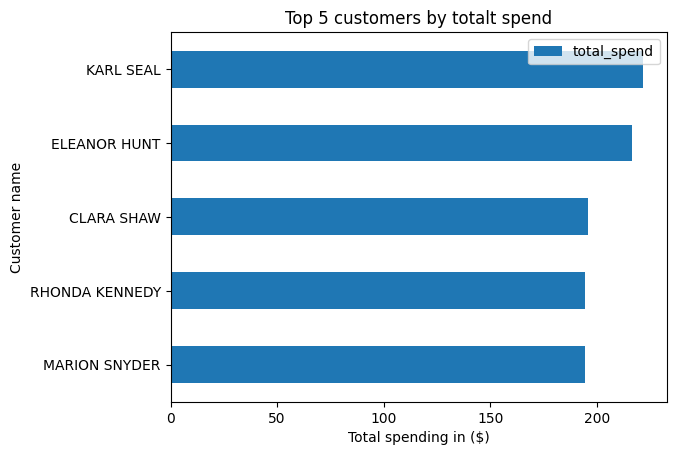

In [19]:
ax = top_5_customers.head().plot(
    kind="barh",
    x="customer_name",
    y="total_spend",
    title="Top 5 customers by totalt spend",
    xlabel="Total spending in ($)",
    ylabel="Customer name"
)
ax.invert_yaxis()

### How much money does each film category bring in? Make a bar chart showing total revenue per film category.

In [20]:
revenue_per_category = duckdb.sql("""
SELECT c.name AS category, 
        SUM(p.amount) AS total_revenue
FROM category c
JOIN film_category fc ON c.category_id = fc.category_id
JOIN film f ON fc.film_id = f.film_id
JOIN inventory i ON f.film_id = i.film_id                                                                                                                                                                            
JOIN rental r ON i.inventory_id = r.inventory_id                                                                                                                                                                            
JOIN payment p ON r.rental_id = p.rental_id
GROUP BY c.name
ORDER BY total_revenue DESC;                                                                                                                                                                                                                                                
""").df()

revenue_per_category

,category,total_revenue
0,Sports,5314.21
1,Sci-Fi,4756.98
2,Animation,4656.30
3,Drama,4587.39
4,Comedy,4383.58
5,Action,4375.85
6,New,4351.62
7,Games,4281.33
8,Foreign,4270.67
9,Family,4226.07


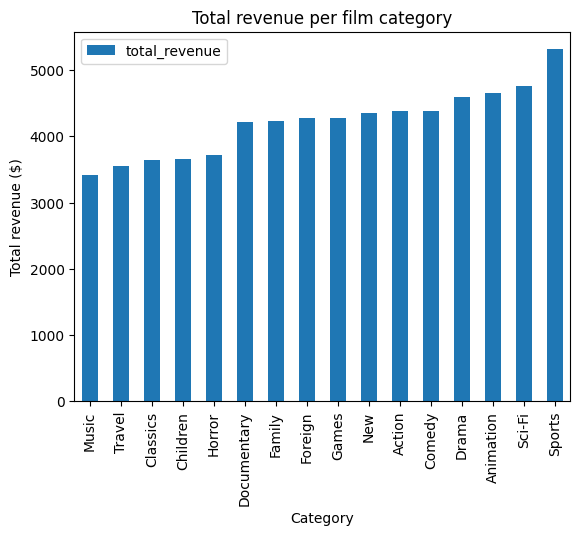

In [22]:
ax = revenue_per_category.plot(
    kind="bar",
    x="category",
    y="total_revenue",
    title="Total revenue per film category",
    xlabel="Category",
    ylabel="Total revenue ($)"
)

ax.invert_xaxis()

# Task 3